# Input Dataset Path Below

# Demo Visualization

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import glob
from pathlib import Path
import os

In [2]:
# Replace with path to your data folder
data_dir = '/Users/fionaluo/Documents/Research/projects/gym-lowcostrobot/examples/demos-fixed'

# Number of demos to visualize
n_demos = 10

In [4]:
# Output directory for visuals
last_folder_name = os.path.basename(data_dir) # Get the last folder name
output_dir = os.path.join("data_visuals-fixed", last_folder_name)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

print(output_dir)

data_visuals-fixed/demos-fixed


# Print Keys and Shapes

In [5]:
# Joint names or identifiers for the legend (optional)
joint_labels = [f'Joint {i+1}' for i in range(6)]

# Construct the file path
file_path = os.path.join(data_dir, 'demo_1.npz')

# Load the .npz file
data = np.load(file_path)

for key in data:
    print(key, data[key].shape)

obs/arm_qpos (401, 6)
obs/arm_qvel (401, 6)
obs/image_front (401, 240, 320, 3)
obs/image_top (401, 240, 320, 3)
obs/image_wrist (401, 240, 320, 3)
action (400, 6)
reward (400,)
terminated (400,)
truncated (400,)


In [6]:
# run this cell if you want to edit the demonstration data
edited_demos_dir = "/home/edward/projects/modemv2/modemv2/demonstrations/edited_demos"
os.makedirs(edited_demos_dir, exist_ok=True)
skip = 0

for entry in os.scandir(data_dir):
    if entry.is_file() and entry.name.endswith('.npz'):
        data = np.load(file_path)
        edited_data = {}
        for k, v in data.items():
            edited_data[k] = v[skip:]
        np.savez(os.path.join(edited_demos_dir, entry.name), **edited_data)
        print(f"Saved edited demonstration data to {edited_demos_dir}")


OSError: [Errno 45] Operation not supported: '/home/edward'

# Plot Joints and Actions

In [7]:
def plot_key_data_joints(data_dir, key_name, y_label, n_demos=10, skip=0):
    """
    Plots data for a specified key from multiple demos in a 2x(n_demos//2) grid format, with a single legend for the entire plot.
    Saves the plot.

    Args:
    - data_dir (str): Path to the directory containing demo files.
    - key_name (str): The key to extract data from the .npz files (e.g., 'obs/joints', 'actions').
    - y_label (str): Label for the y-axis (e.g., 'Joint Value', 'Action Value').
    - n_demos (int): Number of demos to plot. Default is 10.
    """
    
    # Set the number of rows and columns to have 2 rows and n_demos // 2 columns
    n_cols = n_demos // 2
    n_rows = 2
    
    # Increase the height to make the figure taller
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, 10))  # Adjust width based on the number of columns
    axes = axes.flatten()  # Flatten to easily access each subplot

    # Create labels for the joints
    joint_labels = [f'Joint {i+1}' for i in range(6)]
    
    # Initialize variable to store the handles and labels for the legend
    handles, labels = None, None

    # Loop through each demo and plot the data
    for i in range(1, n_demos + 1):
        # Construct the file path for the demo
        file_path = os.path.join(data_dir, f'demo_{i}.npz')

        # Load the data from the .npz file
        data = np.load(file_path)

        # Extract the data for the specified key
        key_data = data[key_name][skip:]  # Assuming it's a 2D array (timesteps, features)
        time_steps = np.arange(key_data.shape[0])  # x-axis as timesteps

        # Plot in the corresponding subplot
        ax = axes[i - 1]
        lines = []
        for j in range(key_data.shape[1]):  # Loop through each feature (e.g., joints or actions)
            line, = ax.plot(time_steps, key_data[:, j], label=f'Joint {j+1}')
            lines.append(line)
        ax.set_title(f'Demo {i}')
        ax.set_xlabel('Time (frames)')
        ax.set_ylabel(y_label)
        
        # Capture handles and labels once to use for the global legend
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()

    # Add a main title to the entire figure
    fig.suptitle(key_name.replace('/', '_'), fontsize=16)

    # Add a single legend outside the plot grid, at the center of the right side
    fig.legend(handles, labels, loc='center right', fontsize=12)

    # Adjust layout to avoid overlapping subplots and leave space for the main title and legend
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the legend on the right

    # Define the output directory and file path
    last_folder_name = os.path.basename(data_dir)  # Get the last folder name from data_dir
    output_dir = os.path.join("data_visuals", last_folder_name)
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Use the key_name in the filename, replacing '/' with '_'
    output_file_name = f'{key_name.replace("/", "_")}.png'
    output_path = os.path.join(output_dir, output_file_name)

    # Save the plot as 'key_name.png' in the output directory
    plt.savefig(output_path)

    # Show the plot
    plt.show()

    print(f"Plot saved to {output_path}")

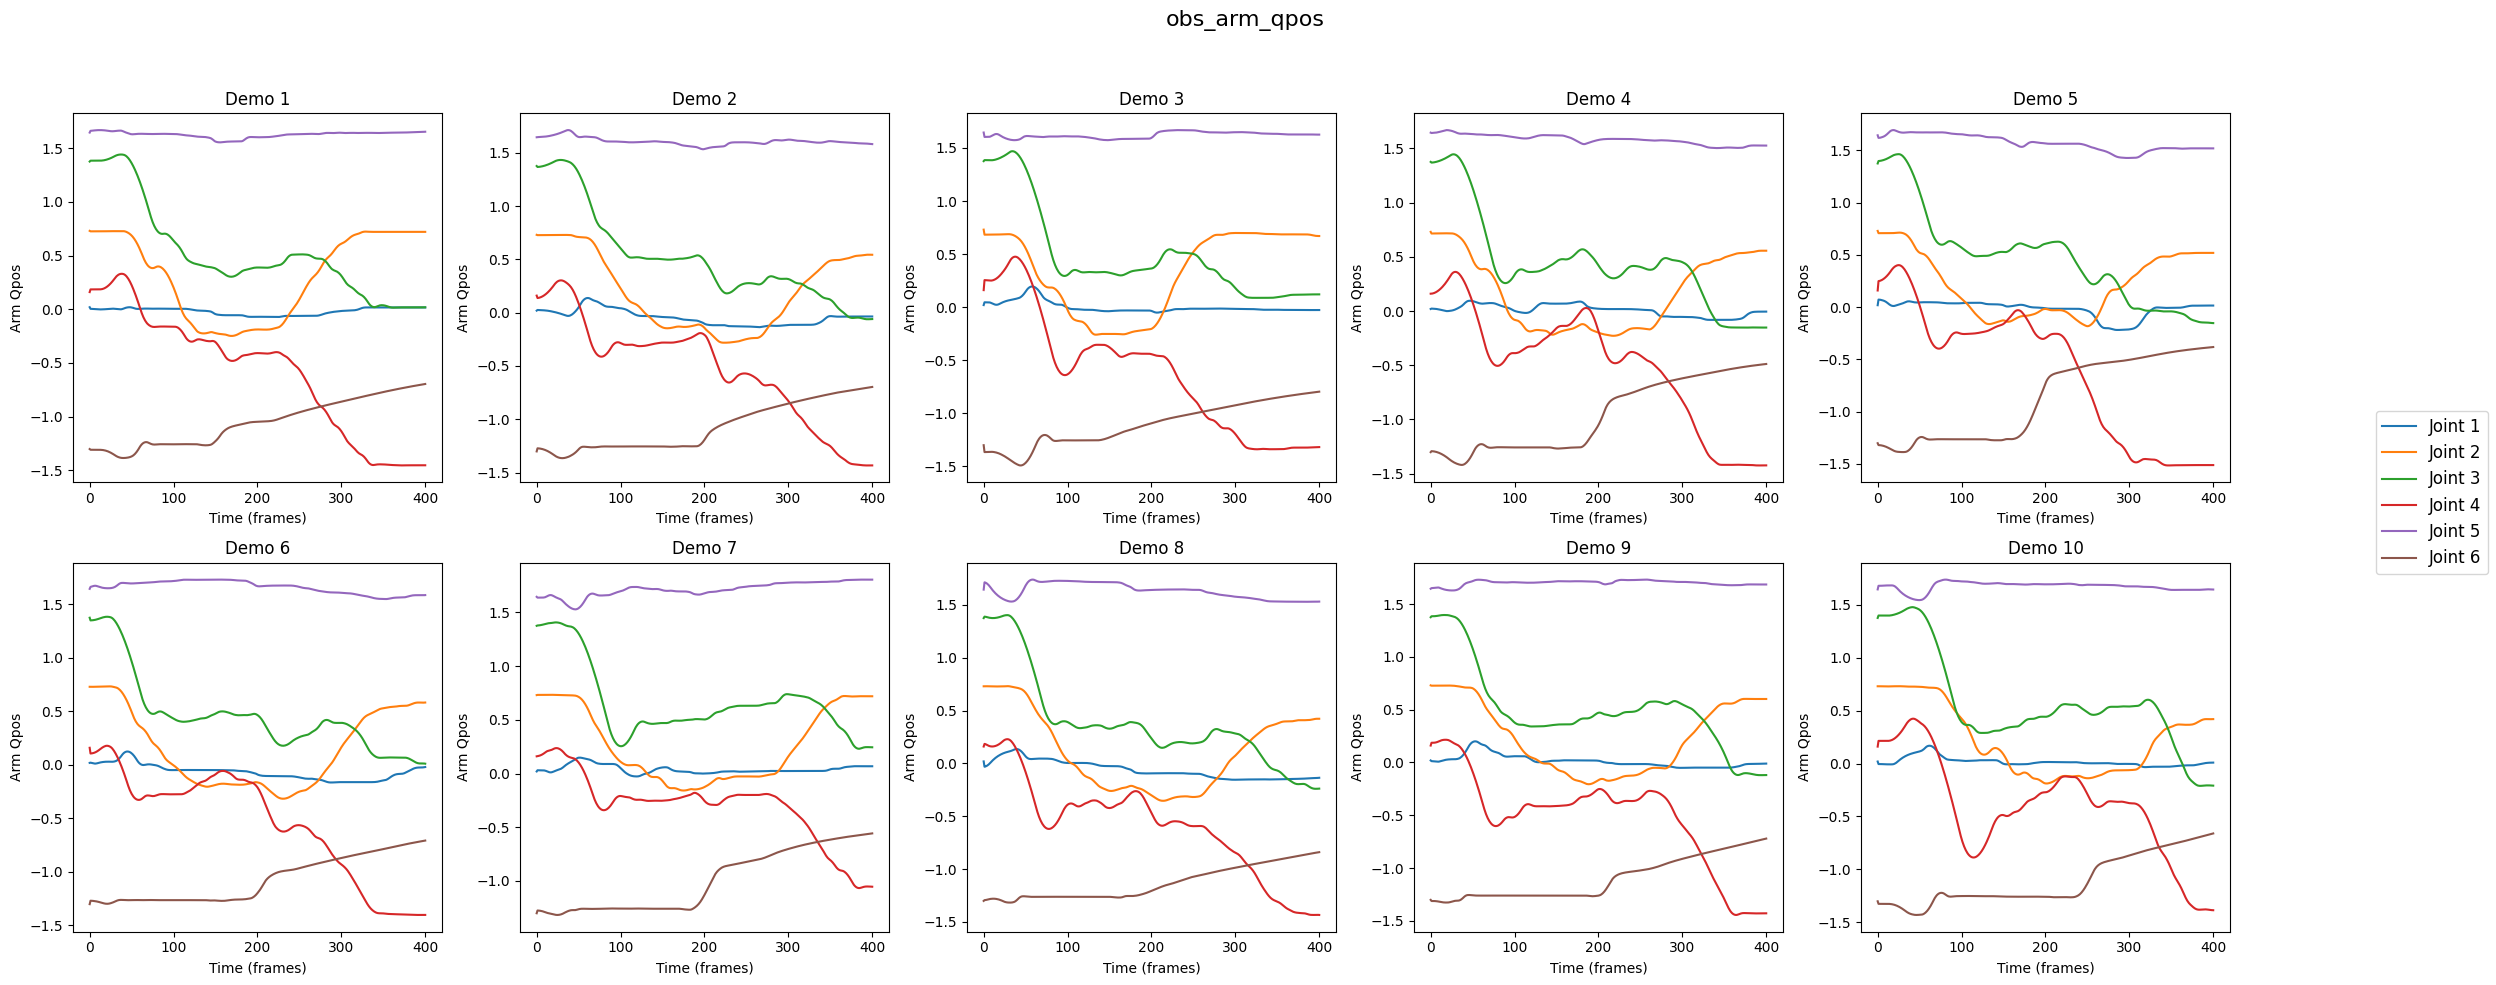

Plot saved to data_visuals/demos-fixed/obs_arm_qpos.png


In [8]:
# Plot for 'obs/joints'
plot_key_data_joints(data_dir, key_name='obs/arm_qpos', y_label='Arm Qpos', n_demos=n_demos, skip=0)

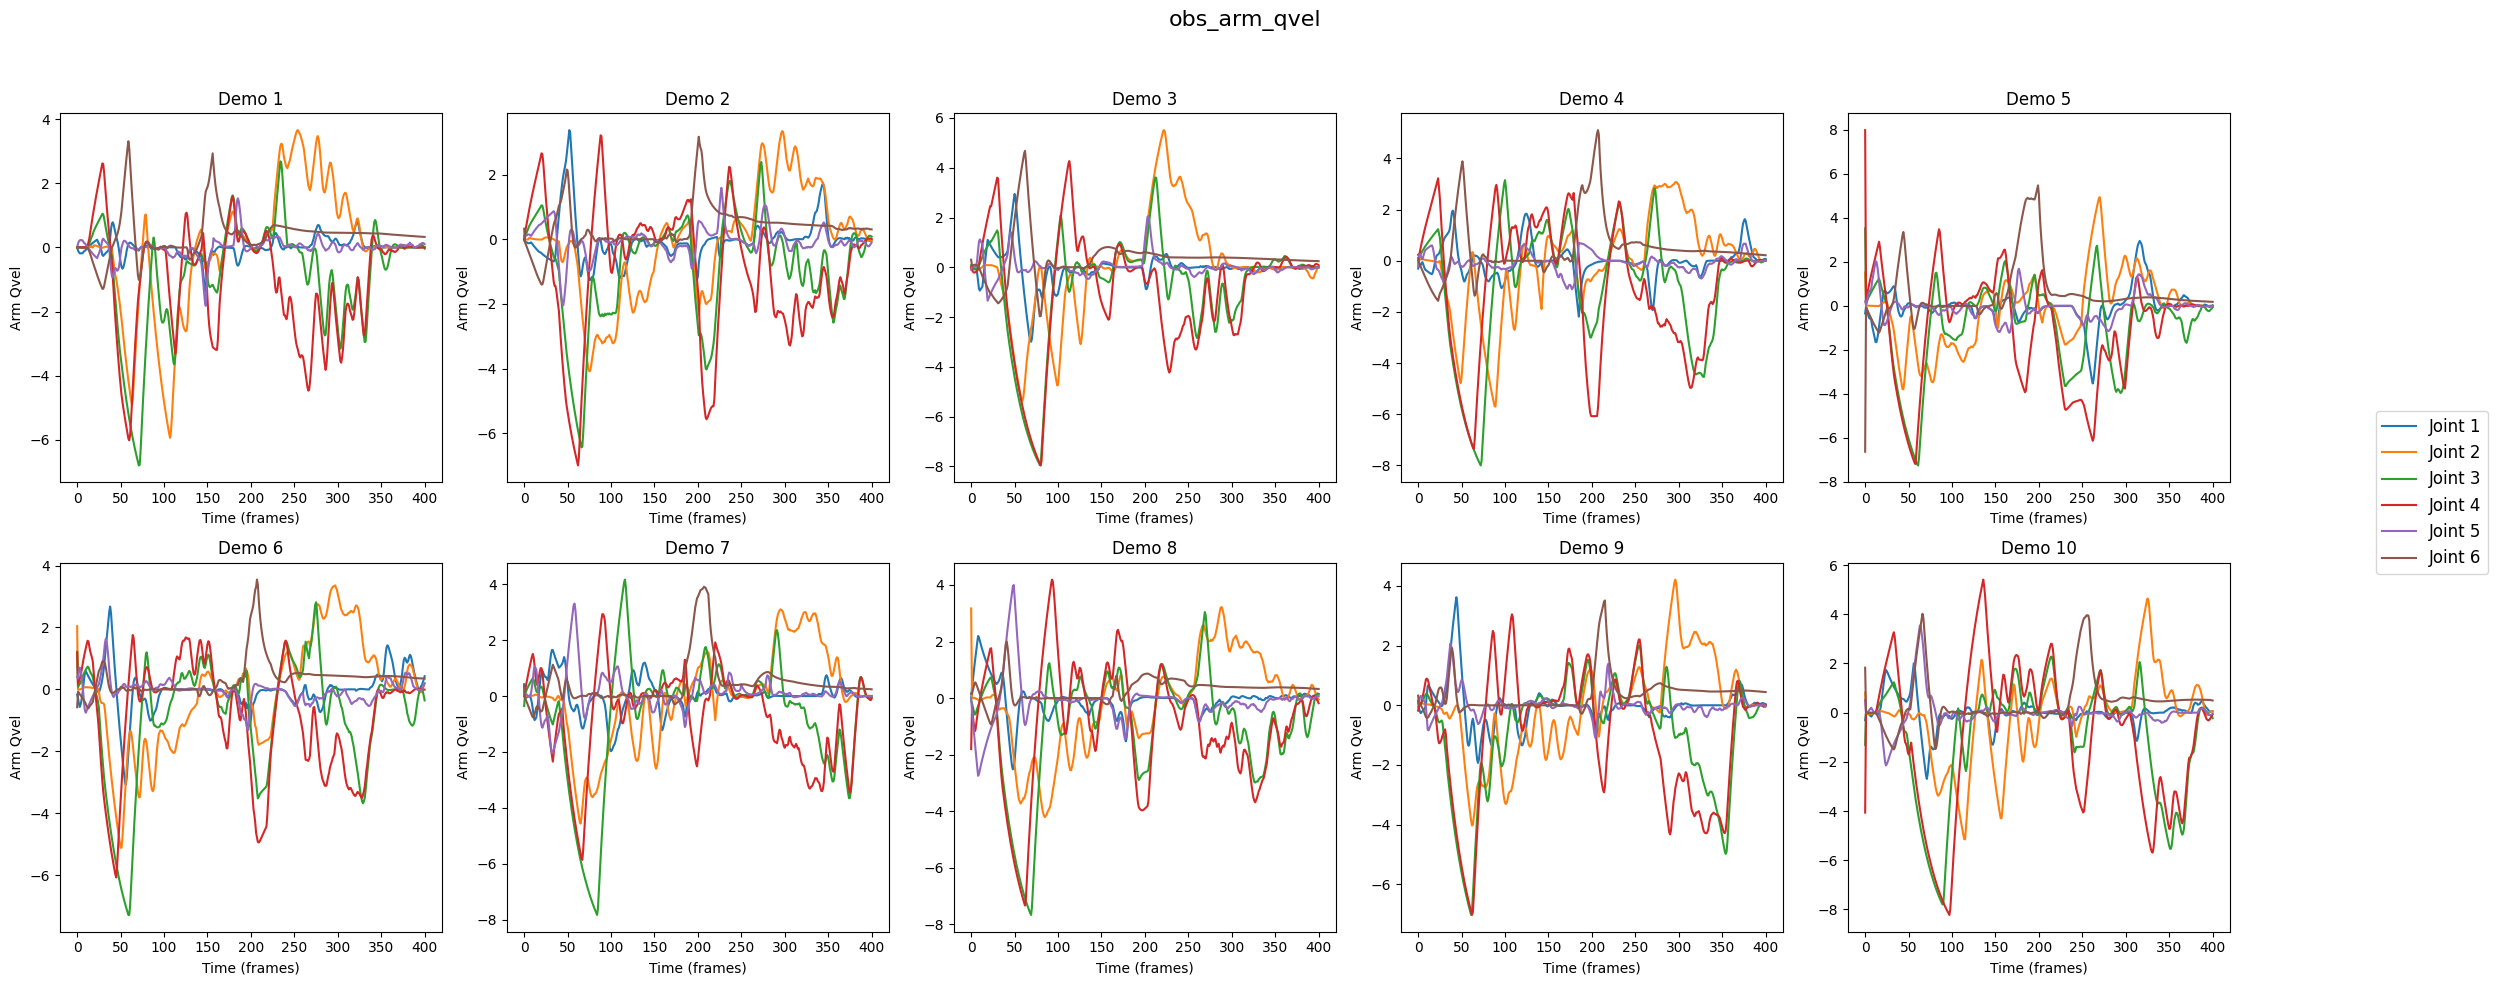

Plot saved to data_visuals/demos-fixed/obs_arm_qvel.png


In [9]:
# Plot for 'qvel'
plot_key_data_joints(data_dir, key_name='obs/arm_qvel', y_label='Arm Qvel', n_demos=n_demos, skip=0)

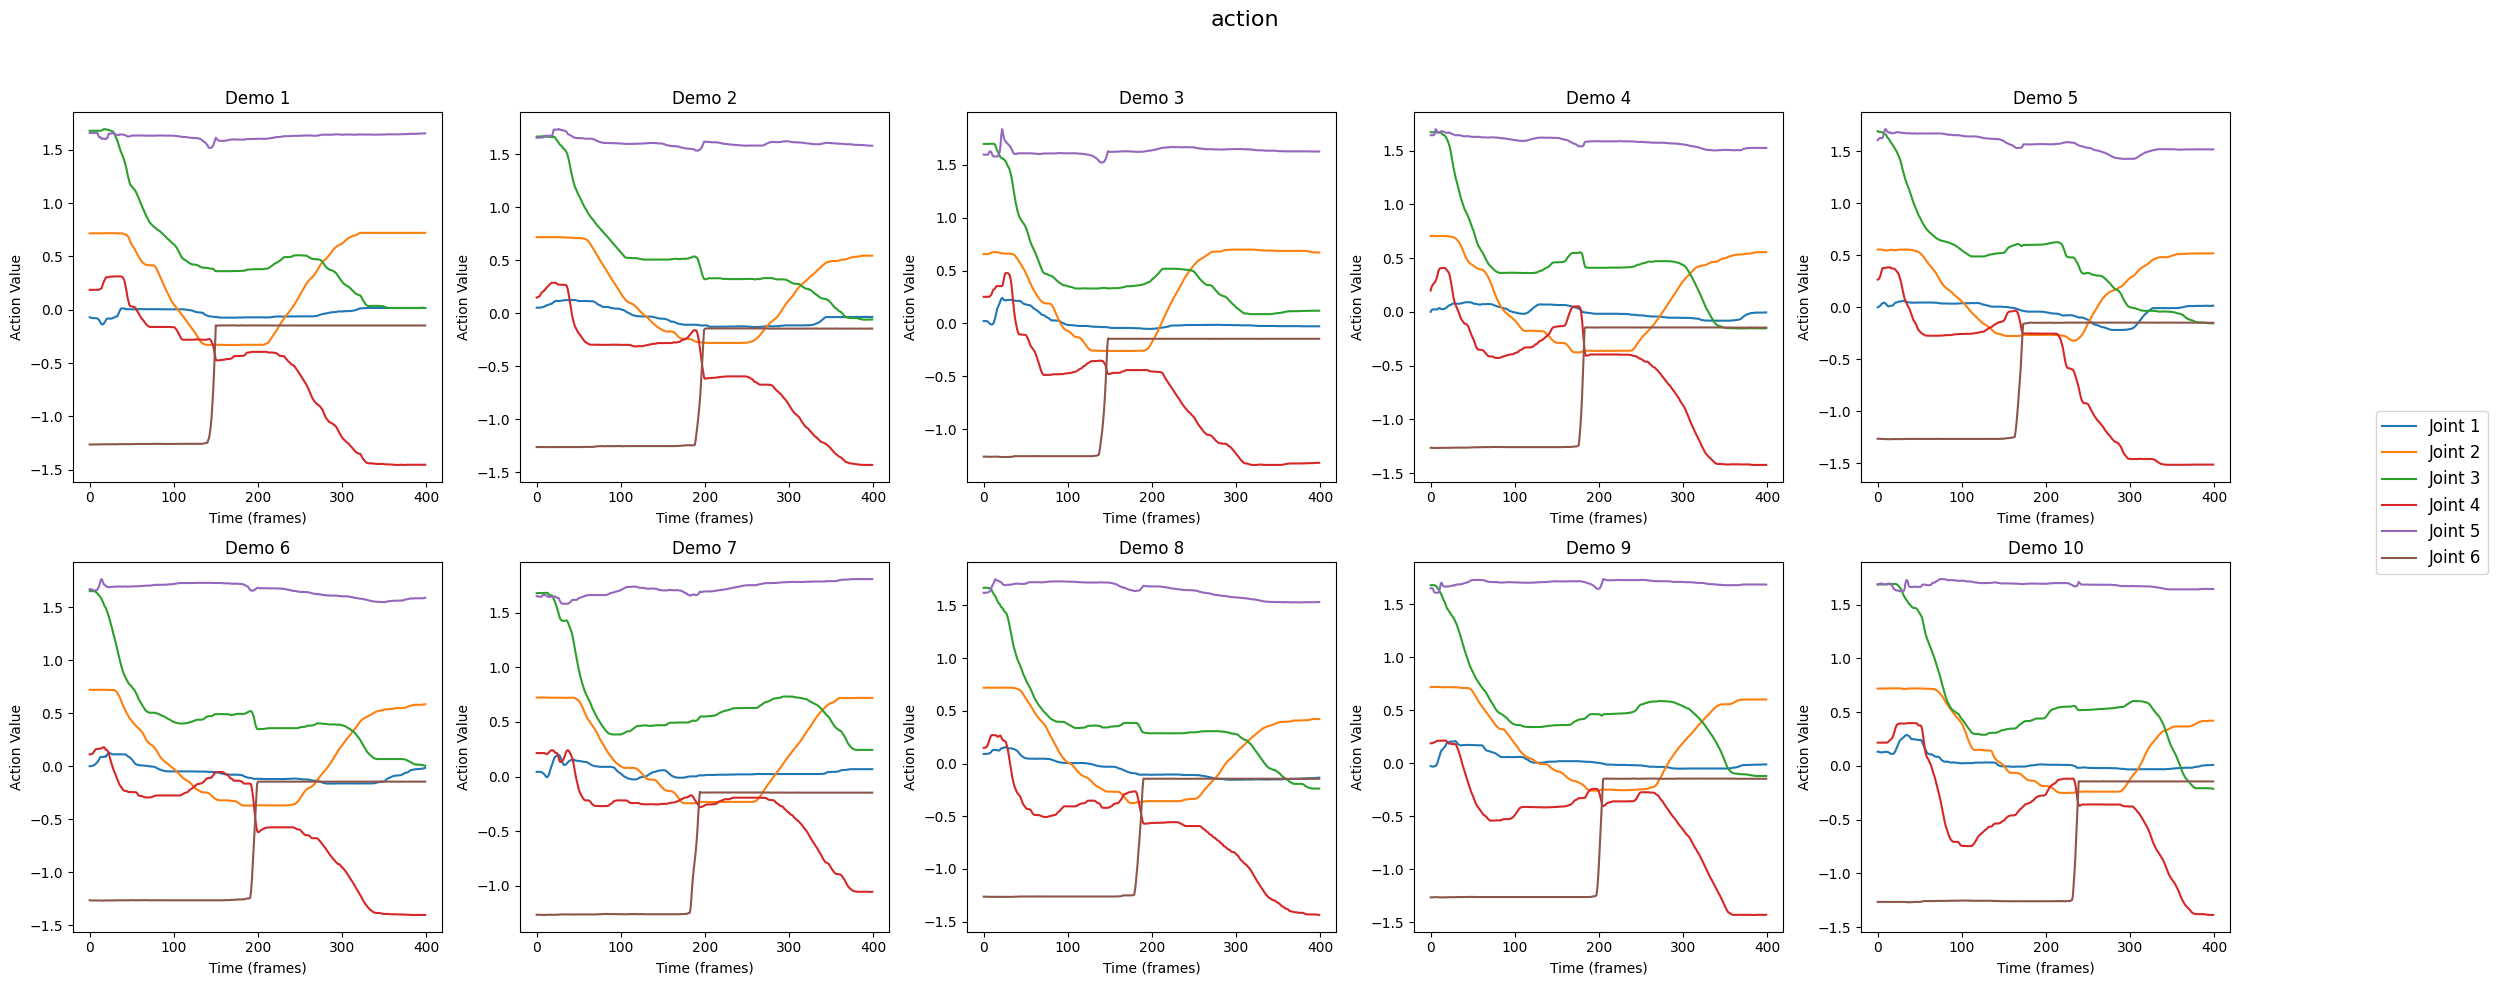

Plot saved to data_visuals/demos-fixed/action.png


In [10]:
# Plot for 'actions'
plot_key_data_joints(data_dir, key_name='action', y_label='Action Value', n_demos=n_demos, skip=0)

# Camera Video Plot (Saved under data_visuals/{dataset}/{key}.mp4)

In [11]:
def create_video_grid(data_dir, key, output_dir, n_demos=10, n_rows=2, skip=0):
    """
    Creates a video grid from wrist camera images of multiple demos and saves it as an MP4 file.
    
    Args:
    - data_dir (str): Path to the directory containing demo files.
    - output_dir (str): Directory where the output video will be saved.
    - n_demos (int): Number of demos to include in the video. Default is 10.
    """
    
    # Parameters for the grid
    n_cols = (n_demos + n_rows - 1) // n_rows  # Number of cols in the grid
    frame_height = 240  # Height of each image
    frame_width = 320   # Width of each image

    # Create a VideoWriter object for MP4
    output_file = os.path.join(output_dir, f"{key.replace('/', '_')}.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video_writer = cv2.VideoWriter(output_file, fourcc, 30.0, (n_cols * frame_width, n_rows * frame_height))

    # Load all demos into memory
    demo_videos = []
    for i in range(1, n_demos + 1):
        # Construct the file path
        file_path = os.path.join(data_dir, f'demo_{i}.npz')
        
        # Load the .npz file
        data = np.load(file_path)
        
        # Extract the "obs/wrist_cam" data
        images = data[key][skip:]  # Assuming this is a 4D array: (timesteps, height, width, channels)
        demo_videos.append(images)

    # Determine the maximum number of timesteps across all demos
    max_timesteps = max(video.shape[0] for video in demo_videos)

    # Create the grid video frame by frame
    for t in range(max_timesteps):
        # Create a blank grid for the current frame
        grid_frame = np.zeros((n_rows * frame_height, n_cols * frame_width, 3), dtype=np.uint8)
        
        for i, video in enumerate(demo_videos):
            if t < video.shape[0]:  # Only process if the video has this frame
                img = video[t]  # Get the current image for demo i
                row = i // n_cols
                col = i % n_cols
                y_offset = row * frame_height
                x_offset = col * frame_width
                grid_frame[y_offset:y_offset + frame_height, x_offset:x_offset + frame_width] = img
                
                # Add a label for each demo
                label = f'Demo {i + 1}'
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(grid_frame, label, (x_offset + 10, y_offset + 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the grid frame to the video
        video_writer.write(grid_frame)

    # Release the video writer
    video_writer.release()

    print(f"Video saved as {output_file}")

In [12]:
# Example usage
create_video_grid(data_dir, 'obs/image_front', output_dir, n_demos=n_demos, skip=20)

Video saved as data_visuals-fixed/demos-fixed/obs_image_front.mp4


In [13]:
# Example usage
create_video_grid(data_dir, 'obs/image_top', output_dir, n_demos=n_demos, skip=20)

Video saved as data_visuals-fixed/demos-fixed/obs_image_top.mp4


In [14]:
# Example usage
create_video_grid(data_dir, 'obs/image_wrist', output_dir, n_demos=n_demos, skip=20)

Video saved as data_visuals-fixed/demos-fixed/obs_image_wrist.mp4


# Plot Reward, Terminated, Truncated

In [15]:
def plot_key_data(data_dir, key_name, y_label, n_demos=10, n_cols=2):
    """
    Plots data for a specified key from multiple demos in a grid format, and saves the plot.

    Args:
    - data_dir (str): Path to the directory containing demo files.
    - key_name (str): The key to extract data from the .npz files (e.g., 'obs/gripper_stuck').
    - y_label (str): Label for the y-axis (e.g., 'Gripper Stuck').
    - n_demos (int): Number of demos to plot. Default is 10.
    - n_cols (int): Number of columns in the plot grid. Default is 2.
    """
    
    # Calculate number of rows for the grid
    n_rows = (n_demos + n_cols - 1) // n_cols
    
    # Create a figure with the specified grid layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()  # Flatten to easily access each subplot

    # Loop through each demo and plot the data
    for i in range(1, n_demos + 1):
        # Construct the file path for the demo
        file_path = os.path.join(data_dir, f'demo_{i}.npz')

        # Load the data from the .npz file
        data = np.load(file_path)

        # Extract the data for the specified key
        key_data = data[key_name]  # Assuming it's a 2D array (timesteps, 1)
        time_steps = np.arange(key_data.shape[0])  # x-axis as timesteps

        # Plot in the corresponding subplot
        ax = axes[i - 1]
        ax.plot(time_steps, key_data, label=f'Demo {i}')
        ax.set_title(f'Demo {i}')
        ax.set_xlabel('Time (frames)')
        ax.set_ylabel(y_label)
        ax.legend(loc='upper right')

    # Add a main title to the entire figure
    fig.suptitle(key_name, fontsize=16)

    # Adjust layout to avoid overlapping subplots and leave space for the main title
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Define the output directory and file path
    last_folder_name = os.path.basename(data_dir)  # Get the last folder name from data_dir
    output_dir = os.path.join("data_visuals", last_folder_name)
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

    output_path = os.path.join(output_dir, f'{key_name.replace('/', '_')}.png')  # Save as key.png

    # Save the plot as 'key.png' in the output directory
    plt.savefig(output_path)

    # Show the plot
    plt.show()

    print(f"Plot saved to {output_path}")

In [16]:
# Gripper Stuck
# plot_key_data(data_dir, key_name='obs/gripper_stuck', y_label='Gripper Stuck')

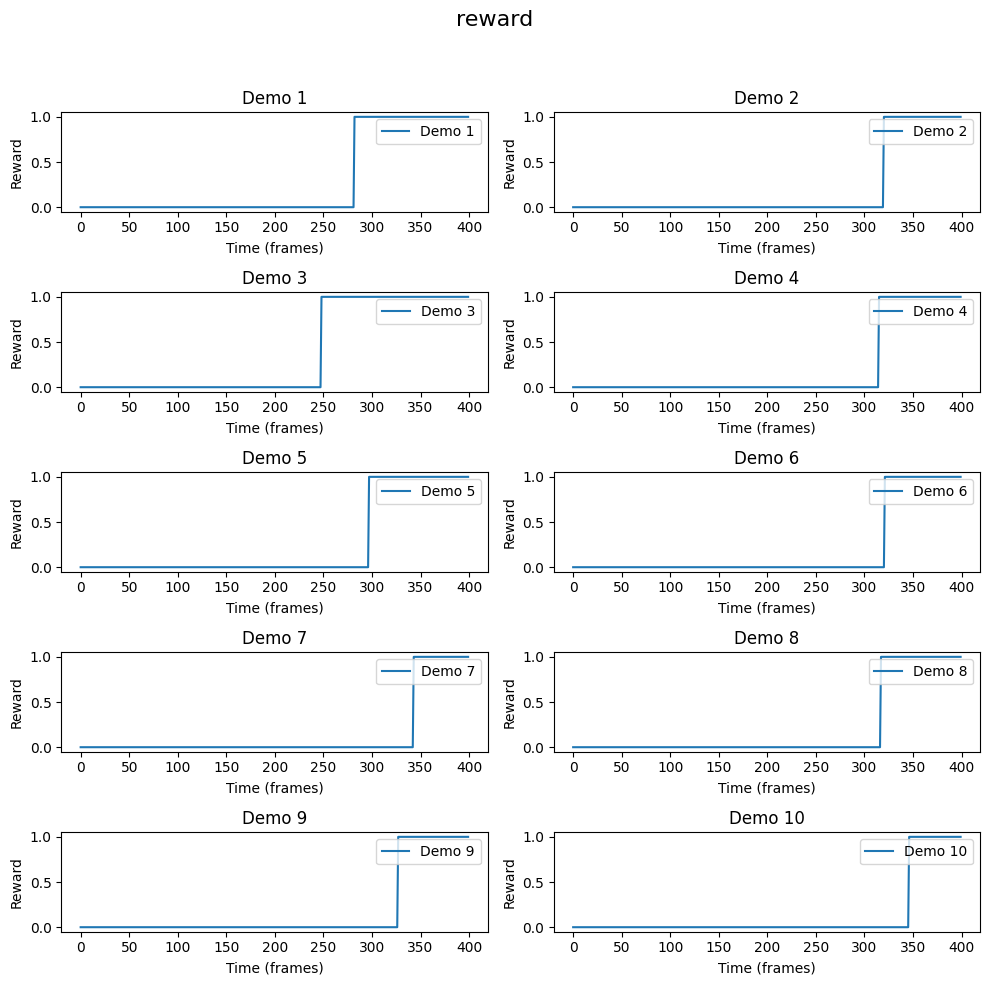

Plot saved to data_visuals/demos-fixed/reward.png


In [17]:
# Reward
plot_key_data(data_dir, key_name='reward', y_label='Reward')

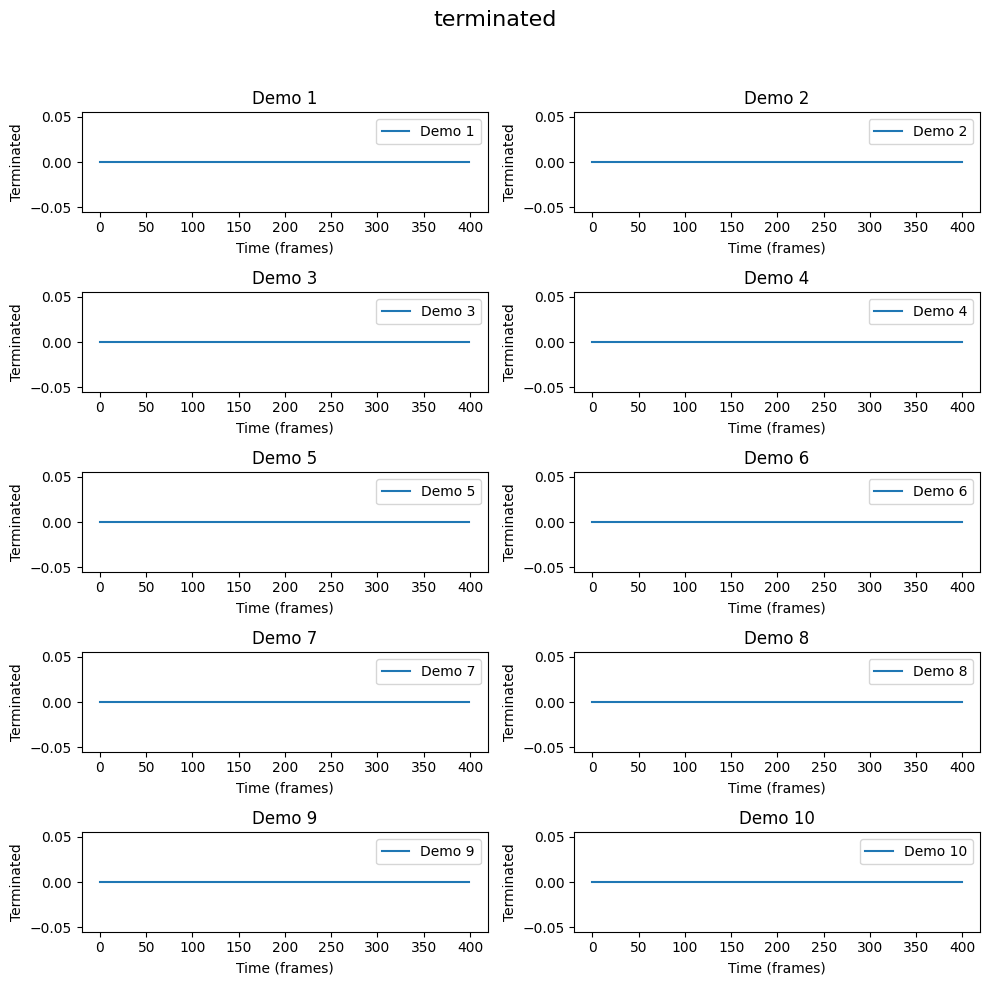

Plot saved to data_visuals/demos-fixed/terminated.png


In [18]:
# Reward
plot_key_data(data_dir, key_name='terminated', y_label='Terminated')

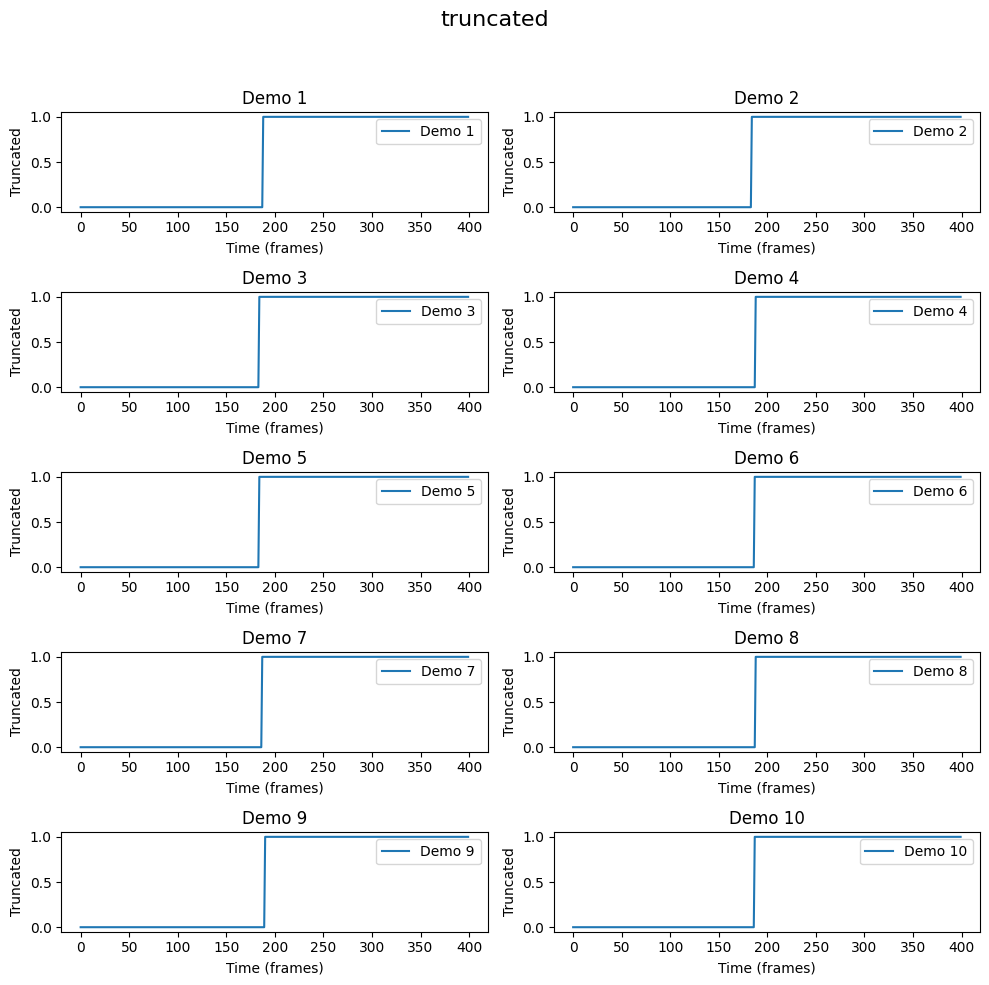

Plot saved to data_visuals/demos-fixed/truncated.png


In [19]:
# Reward
plot_key_data(data_dir, key_name='truncated', y_label='Truncated')